In [3]:
import pysam
import collections
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**User Edit the following cell:**

In [171]:
# folder containing the bamfiles
bam_folder = './spikein_from_bob/'

# folder to write output files to
output_folder = './results'

# enter the input and cmc files
# make sure to order them in correct paired order
input_files = ['HG_input_filtered.bam','HG_FA_input_filtered.bam','LG_input_filtered.bam','LG_FA_input_filtered.bam']
cmc_files = ['HG_CMC_filtered.bam','HG_FA_CMC_filtered.bam','LG_CMC_filtered.bam','LG_FA_CMC_filtered.bam']
# names for each experiment in same order as files
exp_names = ['HG', 'HG_FA', 'LG', 'LG_FA']

# window size for calculating peak values by Carlile method
window_size = 20 

# set to True if want to add +1 pseudocount for each position
pseudocount = True

# file containing known sites
# set as '' if don't want to include known sites
known_sites_file = 'Carlile_known_human_SuppT7_updated.csv'

In [172]:
# check if ouput folder already exists 
if os.path.isdir(output_folder):
    for _, _, files in os.walk(output_folder): 
        if files: # give warning if dir is not empty
            print(f'Warning: {output_folder} has files in it - any same name files will be overwritten')
else: # create dir if it doesn't exist
    os.mkdir(output_folder)

In [6]:
# get the full filenames including path
bamfiles = [os.path.join(bam_folder, bamfile) for bamfile in input_files + cmc_files]

# get just the sample name from the filename
input_samples = [file.split('.')[0] for file in input_files]
cmc_samples = [file.split('.')[0] for file in cmc_files]
samples = input_samples + cmc_samples

exp_peaks = [f'{i}_Peak_ws{window_size}' for i in exp_names]

In [7]:
# get the reference names from a bam file
samfile = pysam.AlignmentFile(bamfiles[0], 'rb')
ref_names = samfile.references

# make a dict to convert the long name to a short abbreviation (if aligned to rRNA)
rrnas = ('5-8S','18S','28S')
ref_name_to_abbrev = {}
for ref_name in ref_names:
    found_rrnas = [rrna for rrna in rrnas if rrna in ref_name]
    if len(found_rrnas) > 1:
        raise SystemError(f'Found multiple rRNA names in {ref_name}')
    if not found_rrnas:
        print(f'Warning: did not find expected rRNA name in {ref_name}')
        ref_name_to_abbrev[ref_name] = ref_name
    else:
        ref_name_to_abbrev[ref_name] = found_rrnas[0]

# ref_names will be 5-8S, 18S, 28S if aligned only to rRNA
ref_names = ref_name_to_abbrev.values()

In [8]:
# read in known Psi sites from Bob's updating of Carlile supplementary table 7
# Bob's positions are in the 'NCBI tx pos' column
# store them in abbrev_ref_to_known {abbrev_ref: [list of known sites]}
rrna_to_known = {}

if known_sites_file:
    known_df = pd.read_csv(known_sites_file)
    
    for rrna in rrnas:
        vals = known_df[known_df['gene name'].str.contains(rrna)]['NCBI tx pos'].values
        rrna_to_known[rrna] = vals

In [9]:
def get_end_count(bamfile, ref_name_to_abbrev):
    '''
    Given a bamfile
    Gets 5' R1 end counts
    Returns 2 nested dicts with keys=[ref_name][pos]
    one will have the counts at each pos, 
    the other has the ref_base at each pos
    '''
    samfile = pysam.AlignmentFile(bamfile, 'rb')
    reads = samfile.fetch()
    
    counts = {}
    bases = {}
    
    for read in reads:
        if read.is_read1 and not read.is_reverse:
            ref = ref_name_to_abbrev[read.reference_name]
            pos = read.reference_start + 1 # Read 1, 5-prime (add 1 since pysam 0-based)
            base = read.get_reference_sequence()[0].upper()
            if ref not in counts:
                counts[ref] = collections.defaultdict(int)
                bases[ref] = {}

            counts[ref][pos] += 1
            if pos in bases[ref] and bases[ref][pos] != base:
                raise SystemError(f'Different bases found at position {pos}: current={base} previous={bases[ref][pos]}')
            bases[ref][pos] = base
    
    return counts, bases

In [10]:
# get 5' R1 end counts, along with corresponding bases for each sample
counts = {}
bases = {}
for sample, bamfile in zip(samples, bamfiles):
    print(f'Getting counts from {sample}...')
    counts[sample], bases[sample] = get_end_count(bamfile, ref_name_to_abbrev)

Getting counts from HG_input_filtered...
Getting counts from HG_FA_input_filtered...
Getting counts from LG_input_filtered...
Getting counts from LG_FA_input_filtered...
Getting counts from HG_CMC_filtered...
Getting counts from HG_FA_CMC_filtered...
Getting counts from LG_CMC_filtered...
Getting counts from LG_FA_CMC_filtered...


In [11]:
# convert to a pandas dataframe (one for each ref_name)
ref_df = {}
for ref_name in ref_names:
    # get the counts from each sample for that ref_name
    # also find the maximum pos across all samples
    d = {}
    combined_bases = {}
    max_pos = -1
    for sample in samples:
        d[sample] = counts[sample][ref_name]
        combined_bases.update(bases[sample][ref_name])
        max_pos = max(max_pos, max(d[sample]))

    # find any positions that got zero reads in all samples
    # assign one sample to have a 0 there, and the rest of
    # the sample will get filled in with NaN and then 0 later
    for i in range(1,max_pos+1):
        if i not in combined_bases:
            d[sample][i] = 0 # just assign it to one of the samples
            combined_bases[i] = '-'

    df = pd.DataFrame.from_dict(d)
    df = df.fillna(0) # replace NaN with 0 for positions that had no counts
    
    if pseudocount: # add 1 pseudocount for each position
        df += 1
        
    df['Sequence'] = pd.Series(combined_bases) # add column for bases
    
    # put columns in order of input samples, cmc samples, sequence
    df = df[samples + ['Sequence']]
    
    # put in dict where key = ref_name
    ref_df[ref_name] = df

In [12]:
def end_count_summary(df, input_samples, cmc_samples, ref_name, output_folder):
    '''
    Given dataframe, input and cmc samples
    '''
    
    fig, axes = plt.subplots(figsize=(18,len(samples)*3),nrows=len(input_samples), ncols=2)
    for row, (input_sample, cmc_sample) in enumerate(zip(input_samples, cmc_samples)):
        for col, sample in enumerate((input_sample, cmc_sample)):
            counts = df[sample].values
            ax = axes[row,col]
            ax.plot(range(len(counts)), counts)
            #ax.hist(counts)
            ax.set_title(f'{ref_name} {sample}')
            ax.text(.02,.90,f'mean counts per position: {int(np.mean(counts))}',fontsize=18,
                    transform=ax.transAxes)
            ax.set_xlabel('position in gene')
            ax.set_ylabel('end counts')
    png_title = os.path.join(output_folder, f'end_count_summary_{ref_name}.png')
    fig.savefig(png_title)
    print(f'{png_title} was saved')
    plt.close(fig)

In [13]:
for ref_name, df, in ref_df.items():
    end_count_summary(df, input_samples, cmc_samples, ref_name, output_folder)

./results/end_count_summary_18S.png was saved
./results/end_count_summary_28S.png was saved
./results/end_count_summary_5-8S.png was saved


In [14]:
def scale_input(ref_df, input_name, cmc_name, exp_name):
    '''
    Given: dictionary {ref_name: df}, and a pair of input/cmc names
    Scale input to be same total reads as cmc for each input/cmc pair
    df is modified in-place in function (don't need to return it)
    '''
    # get total reads for input and CMC over all refs
    cmc_total = input_total = 0
    for df in ref_df.values():
        cmc_total += df[cmc_name].sum()
        input_total += df[input_name].sum()

    ratio = cmc_total / input_total

    # multiply the input reads times the cmc/input ratio
    for df in ref_df.values():  # for each reference gene
        scaled_input = df[input_name].copy()
        scaled_input *= ratio
        df[input_name + '_scaled'] = pd.Series(scaled_input)

    print(f'{exp_name}\t{int(input_total):<8}\t{int(cmc_total):<8}\t{ratio:.4f}')

In [15]:
# scale the input counts for each input/cmc pair
print(f'Exp.\tInput_total\tCMC_total\tCMC/Input_ratio')
for exp_name, input_name, cmc_name in zip(exp_names, input_samples, cmc_samples):
    scale_input(ref_df, input_name, cmc_name, exp_name)  

Exp.	Input_total	CMC_total	CMC/Input_ratio
HG	92139   	122254  	1.3268
HG_FA	94970   	100065  	1.0536
LG	96404   	119069  	1.2351
LG_FA	148995  	116494  	0.7819


In [16]:
def get_peak_value(cmc_vals, inp_vals, pos, ws, verbose=False):
    '''
    Given: series of end counts for cmc/input pair and 
    a position and window-size
    Calculates peak value by looking at the end counts at 
    the 3' base (+1 from given position)
    Returns: peak value
    '''
    pos += 1 # look at 3' base where termination should pile up
    
    if pos > len(cmc_vals): # can't do last base since nothing is 3'
        return np.nan

    r_cmc = cmc_vals.loc[pos]
    r_inp = inp_vals.loc[pos]
    
    # for example if want to look at position 5 with ws=4
    # windows will include positions (3,4,5,6,7)
    lo_pos = max(1, pos - int(ws/2))
    hi_pos = pos + int(ws/2)
    
    wr_cmc = cmc_vals.loc[lo_pos:hi_pos].sum() - r_cmc
    wr_inp = inp_vals.loc[lo_pos:hi_pos].sum() - r_inp

    if (wr_cmc + wr_inp) == 0:
        return np.nan
    peak = ws * (r_cmc - r_inp) / (wr_cmc + wr_inp)
    
    if verbose:
        print(f'3-prime position to look at: {pos}')
        print(f'cmc reads at pos {pos}: {r_cmc}')
        print(f'input reads at pos {pos}: {r_inp}')
        print(f'pos: {pos}, lo_pos: {lo_pos}, hi_pos: {hi_pos}')
        print(cmc_vals.loc[lo_pos:hi_pos])
        print(inp_vals.loc[lo_pos:hi_pos])
        print(f'peak: {peak}')
    return peak

In [17]:
# calculate peak values for each input/cmc pair
for exp_peak, input_name, cmc_name in zip(exp_peaks, input_samples, cmc_samples):
    print(exp_peak)
    for ref_name, df in ref_df.items(): # for each reference gene
        print('> ' + ref_name)
        peaks = []
        for pos in df.index: # for each position
            peaks.append(get_peak_value(df[cmc_name], df[input_name + '_scaled'], pos, window_size))
        df[exp_peak] = peaks
        
# save df as csv for each reference gene
for ref_name, df in ref_df.items(): 
    # next line is to make sure cols are in right order
    df = df[samples + ['Sequence'] + [i+'_scaled' for i in input_samples] + exp_peaks]
    output_name = os.path.join(output_folder, f'{ref_name}.csv')
    df.to_csv(output_name)
    print(f'{output_name} file was saved')

HG_Peak_ws20
> 18S
> 28S
> 5-8S
HG_FA_Peak_ws20
> 18S
> 28S
> 5-8S
LG_Peak_ws20
> 18S
> 28S
> 5-8S
LG_FA_Peak_ws20
> 18S
> 28S
> 5-8S
./results/18S.csv file was saved
./results/28S.csv file was saved
./results/5-8S.csv file was saved


In [18]:
def make_scatter(df, exp_peaks, ref_name, known_sites, output_folder, show_plot=False):
    '''
    Given:
    df: dataframe for a particular ref gene
    exp_peaks: column names for the cols with the peak values
    ref_name: reference gene
    known_sites: list of known positions
    '''  
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    fig, ax = plt.subplots(figsize=(20,8))
    for zorder, (d, color, style, label) in enumerate(cats):
        for exp_peak in exp_peaks:
            x_vals = d.index
            y_vals = d[exp_peak]
            ax.plot(x_vals, y_vals, style, color=color, label = label, zorder = zorder)
            label = ''
    ax.set_title(ref_name, fontsize=20)
    ax.set_ylabel('Peak value (Carlile method)',fontsize=14)
    ax.set_xlabel('nt position in gene',fontsize=14)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=20)
    fig.subplots_adjust(right=0.8)
    filename = os.path.join(output_folder, f'{ref_name}_scatter_plot.png')
    fig.savefig(filename)
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

./results/18S_scatter_plot.png was saved...
./results/28S_scatter_plot.png was saved...
./results/5-8S_scatter_plot.png was saved...


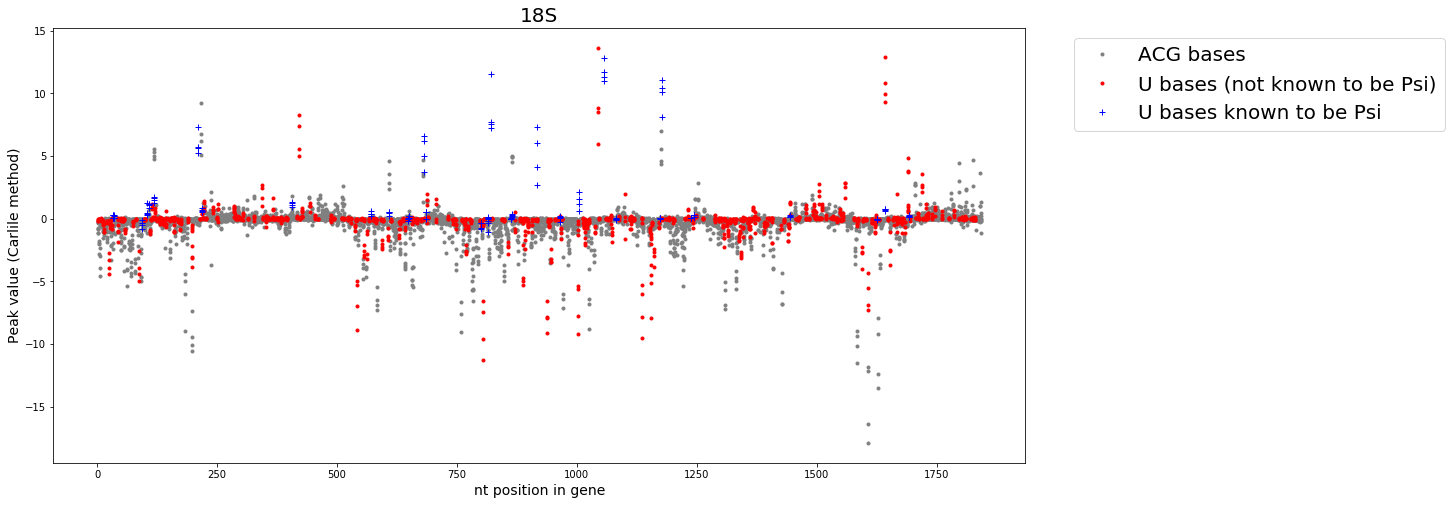

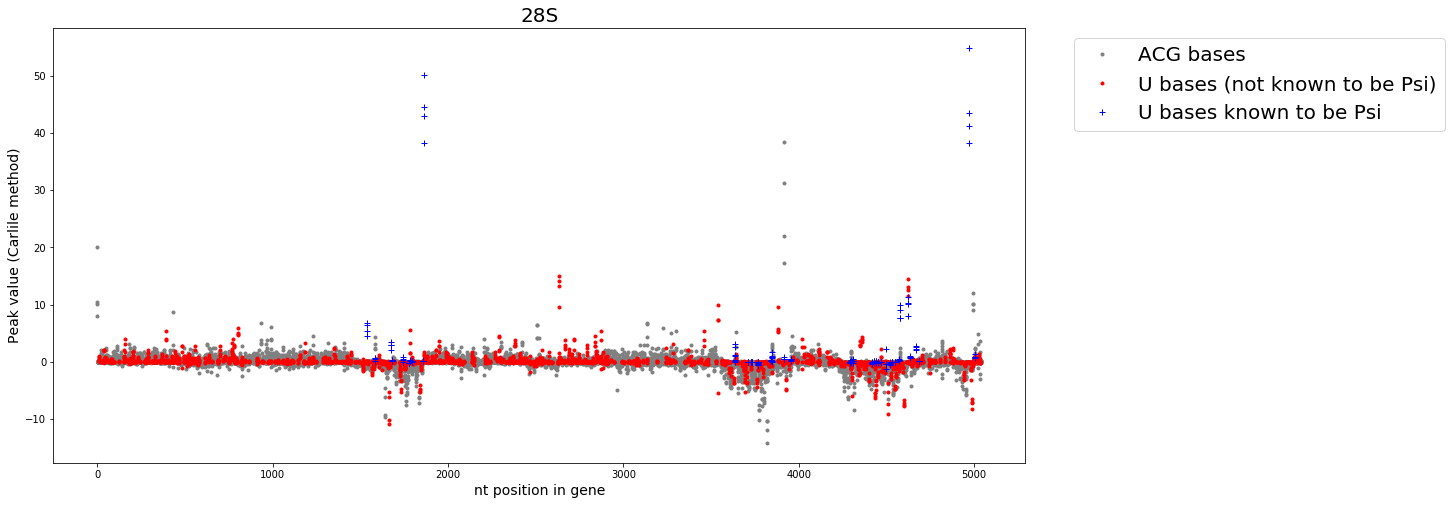

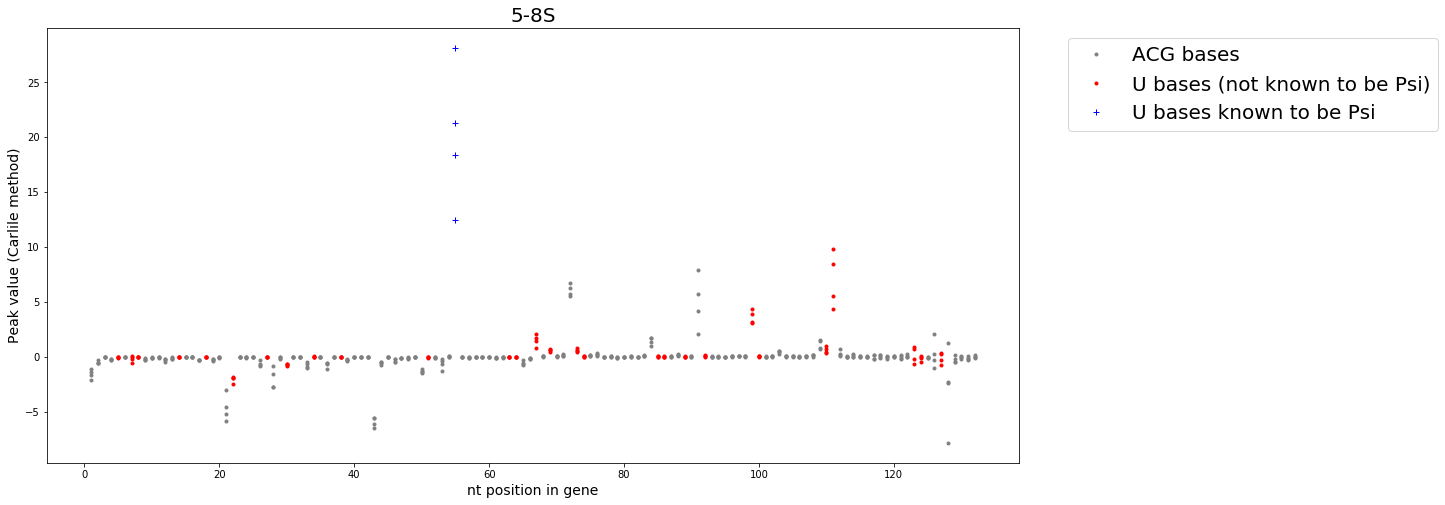

In [19]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, []) # if no known sites given, use empty list
    make_scatter(df, exp_peaks, ref_name, known_sites, output_folder, show_plot=True)

In [229]:
def _plot_line(ax, x1, y1, x2, y2):
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot((x1,x2),(y1,y2),'--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [267]:
def _center_ylim(ax):
    max_ylim = max([abs(i) for i in ax.get_ylim()])
    ax.set_ylim(-max_ylim, max_ylim)

In [307]:
def compare_exps(df, exp_peaks, ref_name, known_sites, output_folder, 
                 by_position=True, cutoff=None, log_scale=None, show_plot=True):
    '''
    Given:
    df: dataframe for a particular ref gene
    exp_peaks: column names for the cols with the peak values
    ref_name: reference gene
    known_sites: list of known positions
    Make scatter plots comparing each pair of experiments
    '''
    
    if cutoff:
        df = df[(df[exp_peaks]>cutoff).all(axis='columns')]
        # apply cutoff to ALL experiments at that position
        # alternative is to just apply to each pair of experiments
        
        # need to get rid of known_sites that didn't pass cutoff
        # otherwise pandas generates a warning when try to use .loc
        known_sites = [site for site in known_sites if site in df.index]
        
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    nrows = ncols = len(exp_peaks)
    
    fig, axes = plt.subplots(figsize=(12,12),nrows=nrows,ncols=ncols,sharex=True,sharey=True)
    
    for row, exp_a in enumerate(exp_peaks[:-1]):
        for col, exp_b in enumerate(exp_peaks[row+1:]):
            col_adj = col + row
            if col_adj == row:
                axes[row,col_adj].text(0.5, 0.5, exp_a.split('_Peak')[0] + '\n'+ ref_name, 
                                     transform=axes[row,col_adj].transAxes, fontsize=16,
                                     ha='center',va='center')

            for zorder, (d, color, style, label) in enumerate(cats):
                a_vals, b_vals = d[exp_a], d[exp_b]
                if log_scale:
                    a_vals, b_vals = log_scale(a_vals), log_scale(b_vals)
                                               
                if by_position:
                    x_vals = d.index
                    y_vals = (a_vals - b_vals)/np.sqrt(2)
                else:
                    x_vals, y_vals = b_vals, a_vals

                ax = axes[row,col_adj+1]
                ax.plot(x_vals, y_vals, style, color=color, label=label, zorder=zorder)

    # loop thru again to plot lines and adjust axes limits
    for row, exp_a in enumerate(exp_peaks[:-1]):
        for col, exp_b in enumerate(exp_peaks[row+1:]):
            col_adj = col + row
            ax = axes[row,col_adj+1]
            
            if by_position: 
                _center_ylim(ax) # center so that 0 is in middle of y-axis
                _plot_line(ax, -1000,0,10000,0) # plot horizontal y=0 line
                ax.set_xlim(-.1*df.index.max(),df.index.max()+.1*df.index.max())
                # add extra padding to left and right when setting xlim
                a_name = exp_a.split('_Peak')[0]
                b_name = exp_b.split('_Peak')[0]
                ax.text(.02,.90,f'{a_name} > {b_name}',fontsize=14,transform=ax.transAxes)
                ax.text(.02,.05,f'{b_name} > {a_name}',fontsize=14,transform=ax.transAxes)
            else:
                _plot_line(ax, -100,-100,100,100) # plot y=x diagonal
                ax.set_xlim(left=0) # make sure starts at 0,0 origin
                ax.set_ylim(bottom=0)               
     
    # add final label to the bottom-right 
    axes[row+1,col_adj+1].text(0.5, 0.5, exp_b.split('_Peak')[0] + '\n'+ref_name, 
                          transform=axes[row+1,col_adj+1].transAxes, fontsize=16,
                          ha='center',va='center')
    
    # remove the lower-left axes 
    for i in range(1,nrows):
        for j in range(0,i):
            axes[i,j].set_axis_off()
            
    log_scale_name = ''
    if log_scale:
        log_scale_name = '_' + log_scale.__str__().split()[1].split('\'')[1]
    if by_position:
        plot_type = 'by_position'
    else:
        plot_type = 'scatter'
    
    filename = f'{ref_name}_compare_experiment_{plot_type}_cutoff_{cutoff}{log_scale_name}.png'
    fig.savefig(os.path.join(output_folder, filename))
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

18S_compare_experiment_scatter_cutoff_None.png was saved...
28S_compare_experiment_scatter_cutoff_None.png was saved...
5-8S_compare_experiment_scatter_cutoff_None.png was saved...


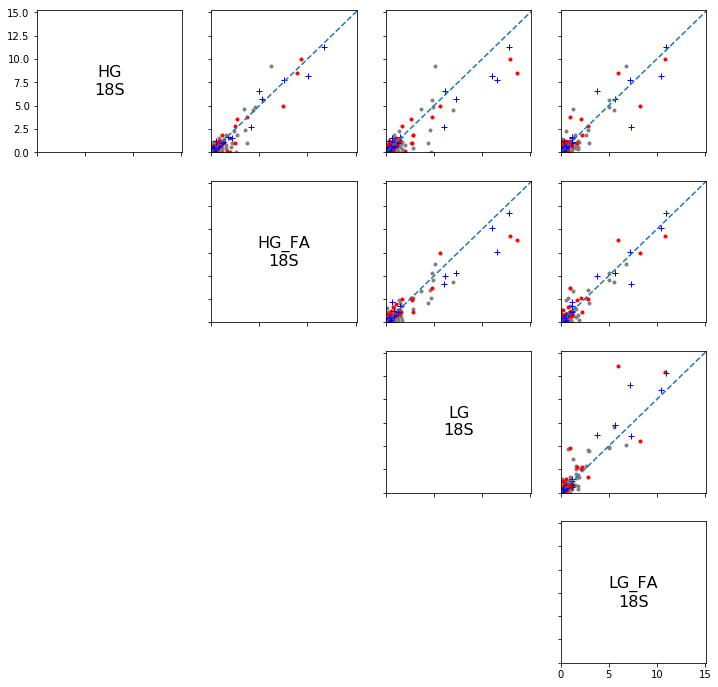

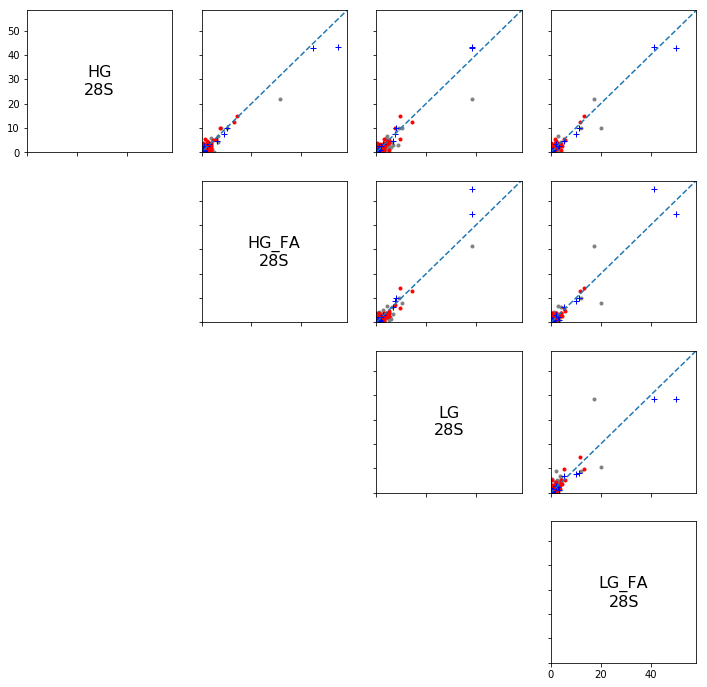

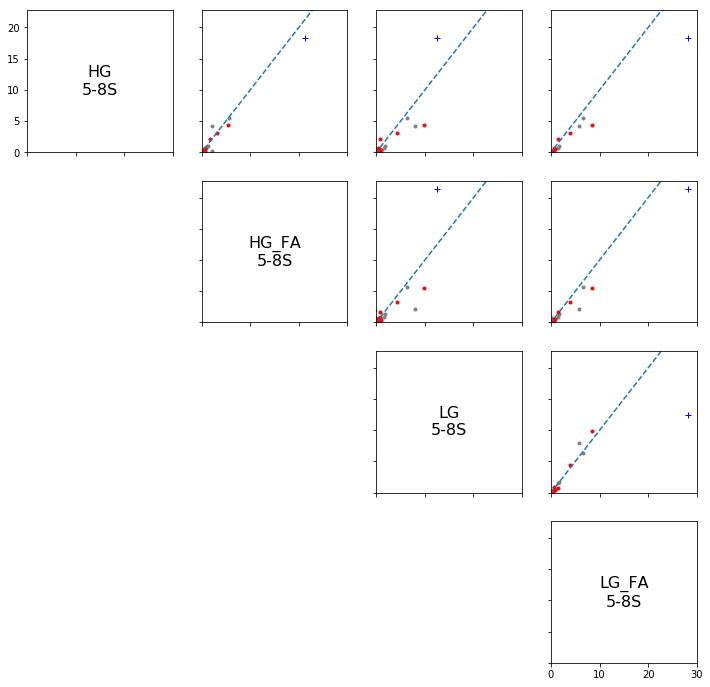

In [310]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, []) # if no known sites given, use empty list
    compare_exps(df, exp_peaks, ref_name, known_sites, output_folder, 
                         by_position=False, cutoff=None,log_scale=None,show_plot=True)

In [276]:
def compare_exps_scatter(df, exp_peaks, ref_name, known_sites, output_folder, 
                         cutoff=None, log_scale=None, show_plot=True):
    '''
    Given:
    df: dataframe for a particular ref gene
    exp_peaks: column names for the cols with the peak values
    ref_name: reference gene
    known_sites: list of known positions
    Make scatter plots comparing each pair of experiments
    '''
    
    if cutoff:
        df = df[(df[exp_peaks]>cutoff).all(axis='columns')]
        # apply cutoff to ALL experiments at that position
        # alternative is to just apply to each pair of experiments
        
        # need to get rid of known_sites that didn't pass cutoff
        # otherwise pandas generates a warning when try to use .loc
        known_sites = [site for site in known_sites if site in df.index]
        
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    nrows = ncols = len(exp_peaks)
    
    fig, ax = plt.subplots(figsize=(12,12),nrows=nrows,ncols=ncols,sharex=True,sharey=True)
    
    for row, exp_a in enumerate(exp_peaks[:-1]):
        for col, exp_b in enumerate(exp_peaks[row+1:]):
            col_adj = col + row
            if col_adj == row:
                ax[row,col_adj].text(0.5, 0.5, exp_a.split('_Peak')[0] + '\n'+ ref_name, 
                                     transform=ax[row,col_adj].transAxes, fontsize=16,
                                     ha='center',va='center')
            overall_min = 1000 # use to add y=x line without changing xlim, ylim (maybe better way to do this)
            overall_max = -1000
            for zorder, (d, color, style, label) in enumerate(cats):
                
                x_vals, y_vals = d[exp_b], d[exp_a]
                
                if log_scale:
                    x_vals, y_vals = log_scale(x_vals), log_scale(y_vals)

                ax[row,col_adj+1].plot(x_vals, y_vals, style, color=color, label=label, zorder=zorder)
                overall_min = min(min(x_vals),min(y_vals),overall_min)
                overall_max = max(max(x_vals),max(y_vals),overall_max)
            ax[row,col_adj+1].plot([overall_min, overall_max],[overall_min, overall_max],'--')
                   
    # add final label to the bottom-right 
    ax[row+1,col_adj+1].text(0.5, 0.5, exp_b.split('_Peak')[0] + '\n'+ref_name, 
                          transform=ax[row+1,col_adj+1].transAxes, fontsize=16,
                          ha='center',va='center')
    
    # remove the lower-left axes 
    for i in range(1,nrows):
        for j in range(0,i):
            ax[i,j].set_axis_off()
            
    log_scale_name = ''
    if log_scale:
        log_scale_name = '_' + log_scale.__str__().split()[1].split('\'')[1]
    
    filename = f'{ref_name}_compare_experiment_scatter_cutoff_{cutoff}{log_scale_name}.png'
    fig.savefig(os.path.join(output_folder, filename))
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

18S_compare_experiment_scatter_cutoff_1_log2.png was saved...
28S_compare_experiment_scatter_cutoff_1_log2.png was saved...
5-8S_compare_experiment_scatter_cutoff_1_log2.png was saved...


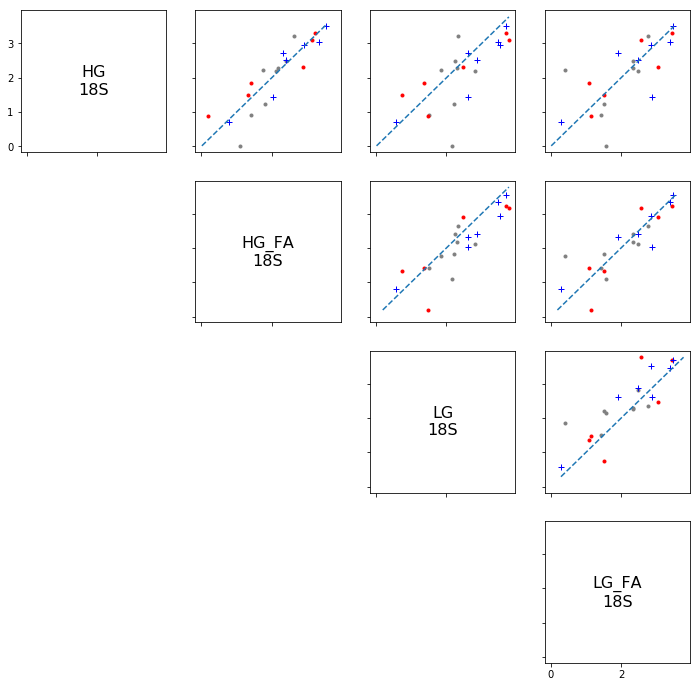

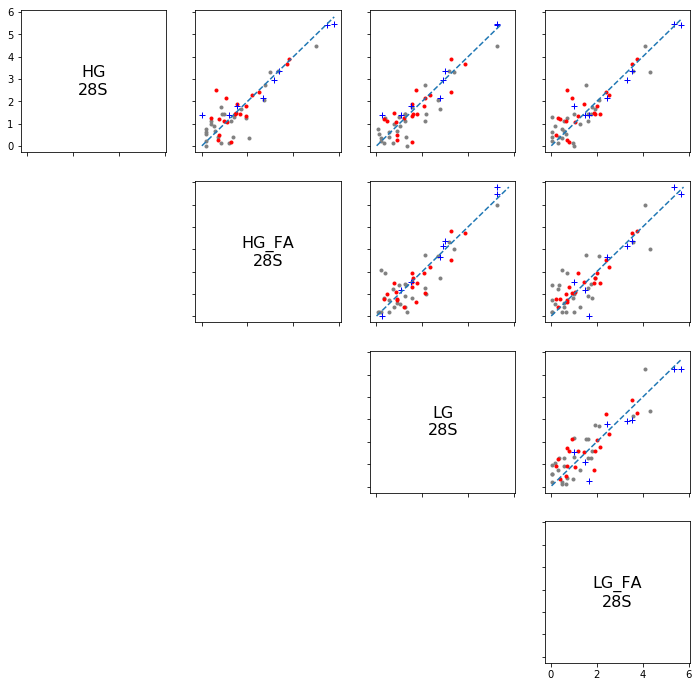

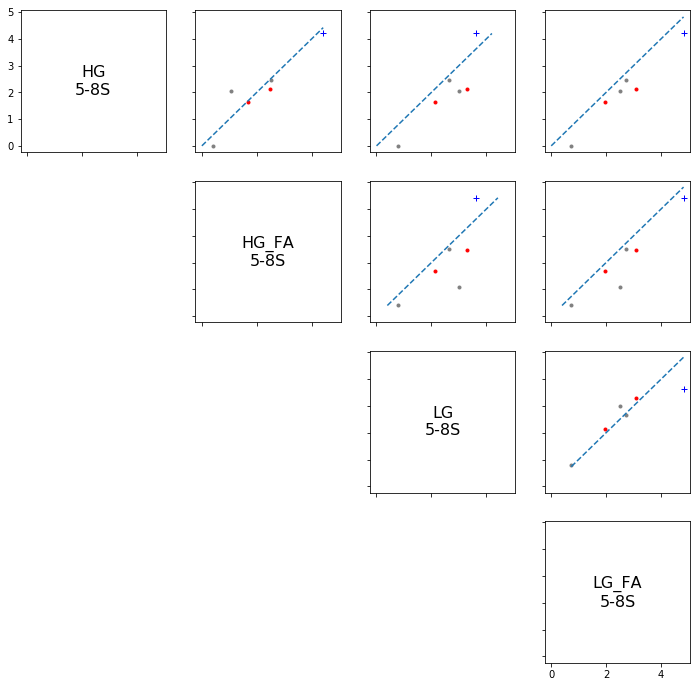

In [208]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, []) # if no known sites given, use empty list
    compare_exps_scatter(df, exp_peaks, ref_name, known_sites, output_folder, 
                         cutoff=1,log_scale=np.log2,show_plot=True)

In [136]:
def _distance_to_diagonal(x_vals, y_vals):
    '''
    Given two series of numbers
    For each pair of numbers calculate the distance from (x,y) to the y=x diagonal
    '''
    distances = []
    for x,y in zip(x_vals, y_vals):
        d = abs(y-x)/np.sqrt(2)
        if x>y:
            d = -d
        distances.append(d)
    return distances
        

In [104]:
def compare_exps_by_position(df, exp_peaks, ref_name, known_sites, output_folder, 
                 cutoff=None, log_scale=None, show_plot=True):
    '''
    Given:
    df: dataframe for a particular ref gene
    exp_peaks: column names for the cols with the peak values
    ref_name: reference gene
    known_sites: list of known positions
    output_folder: where to save plots
    cutoff: only plot values >= cutoff in all experiments
    log_scale: take log of peak values, for example can use np.log2, np.log10, or np.log 
    show_plot: set to False to save plots without displaying in notebook
    
    Plots exp1 - exp2 for each position across gene
    '''
    if cutoff:
        df = df[(df[exp_a]>=cutoff) & (d[exp_b]>=cutoff)]
    
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    nrows = np.math.factorial(len(exp_peaks) - 1)
    
    fig, axes = plt.subplots(figsize=(8,4*nrows),nrows=nrows,sharex=True)
    
    x_max = df.index.max() # number of positions
    
    row = 0
    ylim = 0
    for i, exp_a in enumerate(exp_peaks[:-1]):
        for exp_b in exp_peaks[i+1:]:
            for zorder, (d, color, style, label) in enumerate(cats):
                x_data = d[exp_a].index
                if log_scale and cutoff:
                    y_data = _distance_to_diagonal(
                        log_scale(d[(d[exp_a]>=cutoff) & (d[exp_b]>=cutoff)][exp_b]),
                        log_scale(d[(d[exp_a]>=cutoff) & (d[exp_b]>=cutoff)][exp_a]))
                    x_data = d[(d[exp_a]>=cutoff) & (d[exp_b]>=cutoff)].index
                elif cutoff:
                    y_data = _distance_to_diagonal(
                        d[(d[exp_a]>=cutoff) & (d[exp_b]>=cutoff)][exp_b],
                        d[(d[exp_a]>=cutoff) & (d[exp_b]>=cutoff)][exp_a])
                    x_data = d[(d[exp_a]>=cutoff) & (d[exp_b]>=cutoff)].index
                else:
                    y_data = _distance_to_diagonal(d[exp_b], d[exp_a])
                

                ax = axes[row]
                if cutoff:
                    ax.plot((0,x_max),(0,0),'--',color='gray')
                ax.plot(x_data, y_data, style, color=color, label=label, zorder=zorder)
                a_name = exp_a.split('_Peak')[0]
                b_name = exp_b.split('_Peak')[0]
                ax.set_title(f'{ref_name}: {a_name} vs {b_name}')
                ax.text(.02,.90,f'{a_name} > {b_name}',fontsize=14,transform=ax.transAxes)
                ax.text(.02,.1,f'{b_name} > {a_name}',fontsize=14,transform=ax.transAxes)
                ax.set
                ylim = max((abs(i) for i in ax.get_ylim()))
            row += 1
    for row in range(nrows):
        axes[row].set_ylim(-ylim, ylim)

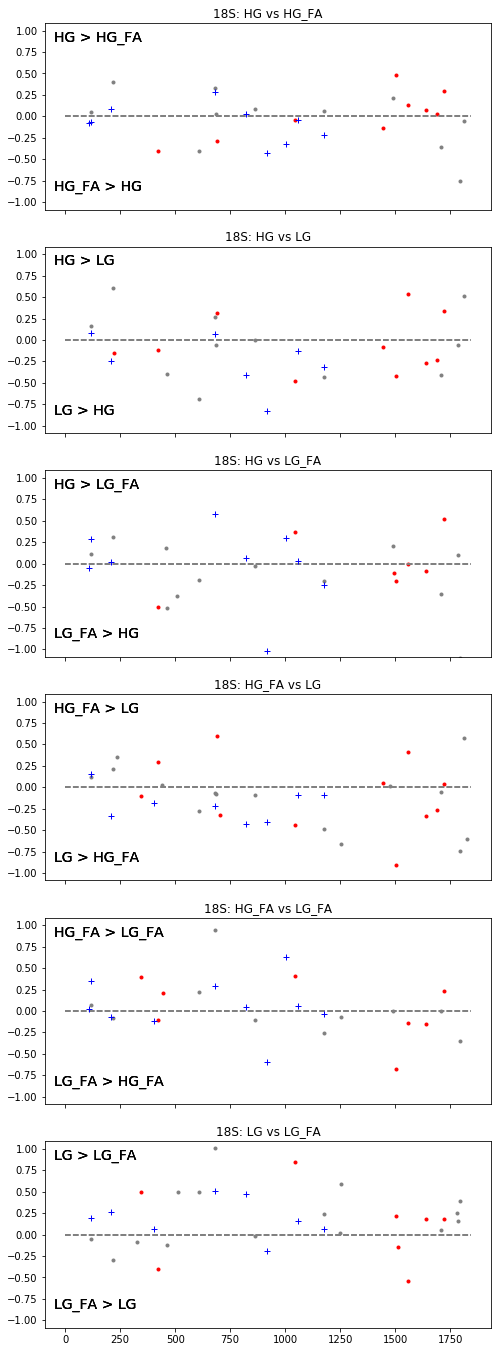

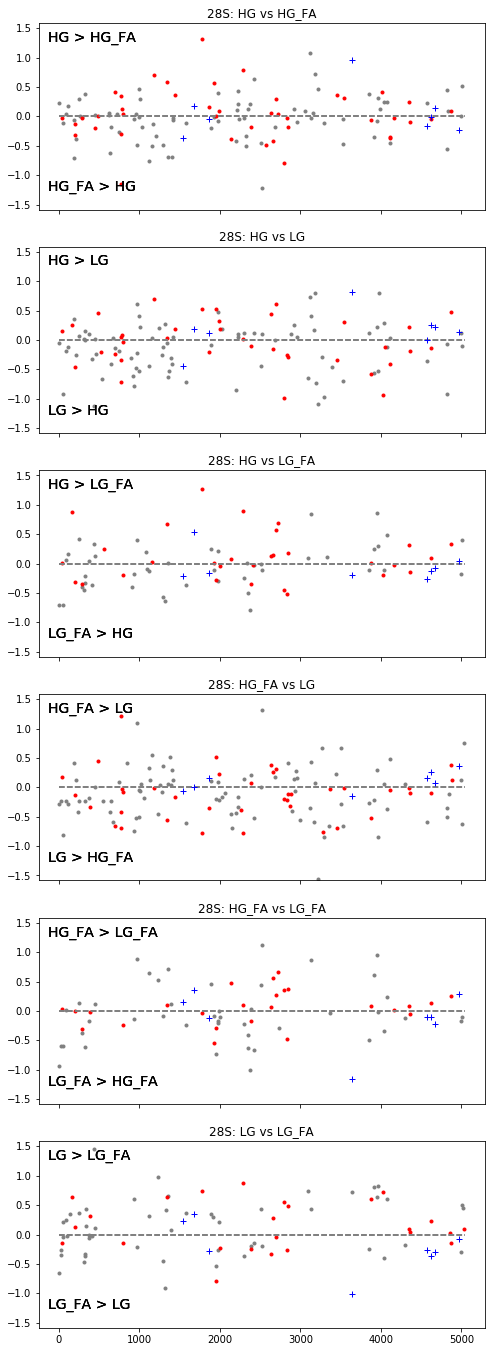

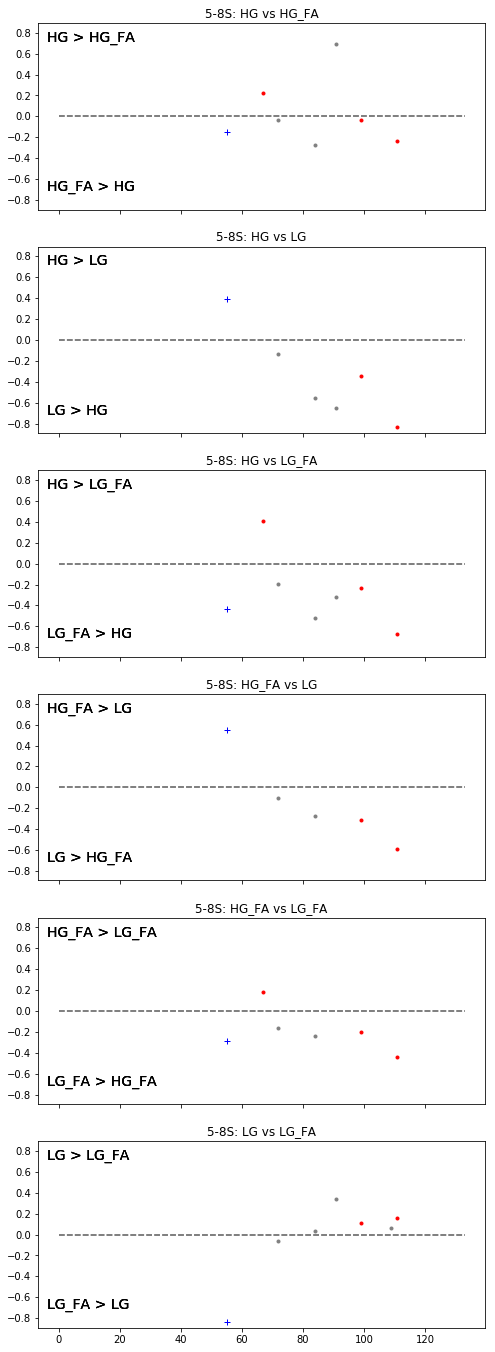

In [143]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, [])
    compare_exps_by_position(df, exp_peaks, ref_name, known_sites, output_folder, 
                 cutoff=1, log_scale=np.log2, show_plot=False)